In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from IPython.display import display
pd.options.display.float_format = "{:,.2f}".format

In [54]:
user_item_interactions = pd.read_csv(
    "../../tests/test_data/user_item_interactions_30_days.csv", parse_dates=["date"]
)
user_item_interactions.shape

(1827358, 4)

The dataset consists of interactions between users and items, 
with a count of interactions each day. The total number of interactions
between each user/item pair will be used to create a rating feature
for collaborative filtering.

In [56]:
# group by user_id and item_id and 
# sum the number of interactions

user_item_interactions_grouped = user_item_interactions.drop(columns=["date"]).groupby(
    ["user_id", "item_id"]
).sum().reset_index()
user_item_interactions_grouped.head(3)

,user_id,item_id,interactions
0,U000003,I00037925,1.00
1,U000003,I00189384,1.00
2,U000003,I00256366,1.00


What's the range of total interactions by user/item?

In [57]:
total_interactions_by_user = user_item_interactions_grouped[["user_id", "interactions"]].groupby("user_id").sum().reset_index()
total_interactions_by_item = user_item_interactions_grouped[["item_id", "interactions"]].groupby("item_id").sum().reset_index()

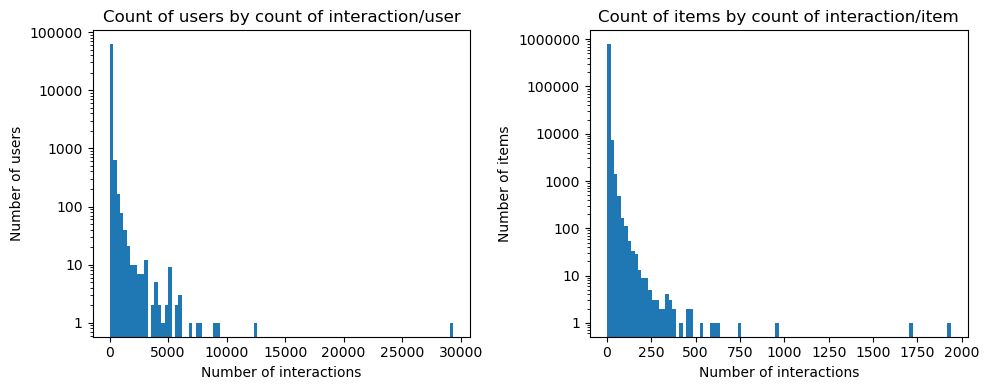

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
ax1.hist(total_interactions_by_user.interactions, log=True, bins=100)
ax2.hist(total_interactions_by_item.interactions, log=True, bins=100)

for ax in (ax1, ax2):
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xlabel("Number of interactions")

ax1.set_title("Count of users by count of interaction/user")
ax2.set_title("Count of items by count of interaction/item")
    
ax1.set_ylabel("Number of users")
ax2.set_ylabel("Number of items")
plt.tight_layout()

plt.show()

As expected, the distributions are heavily skewed towards low numbers of interactions.

In [59]:
# cap the number of interactions to produce 
# a better range of values for ratings
INTERACTION_CAP = 5
user_item_interactions_grouped["interactions_capped"] = np.minimum(
    user_item_interactions_grouped.interactions, INTERACTION_CAP
)
user_item_interactions_grouped["interactions_capped"].value_counts().sort_index()

interactions_capped
1.00    1163526
2.00     253237
3.00      68800
4.00      55743
5.00      33575
Name: count, dtype: int64

In [60]:
# scale the capped interactions to form a rating
user_item_ratings = user_item_interactions_grouped[["user_id", "item_id"]].copy()

user_item_ratings["rating"] = 1 + np.log1p(
    user_item_interactions_grouped["interactions_capped"]
)
user_item_ratings["rating"] = (
    user_item_ratings["rating"] / user_item_ratings["rating"].max()
).round(2)
user_item_ratings.shape

(1574881, 3)

In [61]:
# store ratings mean & count for later use
user_rating_stats = user_item_ratings.groupby("user_id")["rating"].agg(mean='mean', n_ratings='count').reset_index()
item_rating_stats = (
    user_item_ratings.groupby("item_id")["rating"]
    .agg(mean="mean", n_ratings="count")
    .reset_index()
)

display(user_rating_stats.head(3))
display(item_rating_stats.head(3))

print("unique users:", user_rating_stats.shape[0])
print("unique items:", item_rating_stats.shape[0])

,user_id,mean,n_ratings
0,U000003,0.68,23
1,U000004,0.79,5
2,U000005,0.63,7


,item_id,mean,n_ratings
0,I00000001,0.69,4
1,I00000003,0.61,1
2,I00000005,0.61,1


unique users: 62719
unique items: 792547


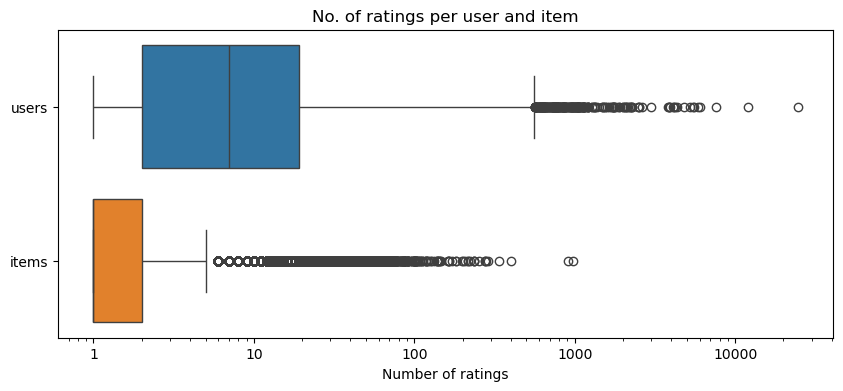

In [62]:
n_ratings = pd.concat(
    [
        user_rating_stats["n_ratings"].to_frame("users"),
        item_rating_stats["n_ratings"].to_frame("items"),
    ],
    axis=1,
).astype(float)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(data=n_ratings, ax=ax, orient="h", log_scale=True)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
ax.set_title("No. of ratings per user and item")
ax.set_xlabel("Number of ratings")

plt.show()

In [63]:
user_rating_counts = (
    user_rating_stats.n_ratings.value_counts().sort_index().to_frame("n_users").reset_index()
)
item_rating_counts = (
    item_rating_stats.n_ratings.value_counts()
    .sort_index()
    .to_frame("n_items")
    .reset_index()
)

user_rating_counts["ratio_users"] = user_rating_counts["n_users"] / user_rating_counts["n_users"].sum()
item_rating_counts["ratio_items"] = item_rating_counts["n_items"] / item_rating_counts["n_items"].sum()

assert user_rating_counts.n_users.sum() == user_rating_stats.shape[0]
assert item_rating_counts.n_items.sum() == item_rating_stats.shape[0]

print(
    f"Users with 1 rating: {user_rating_counts[user_rating_counts['n_ratings'] == 1]['ratio_users'].values[0] * 100:.2f}%"
)
print(
    f"Items with 1 rating: {item_rating_counts[item_rating_counts['n_ratings'] == 1]['ratio_items'].values[0] * 100:.2f}%"
)

Users with 1 rating: 15.84%
Items with 1 rating: 67.16%


In [ ]:
MIN_USER_RATINGS = 5

usable_users = user_rating_stats[
    user_rating_stats["n_ratings"] >= MIN_USER_RATINGS
]["user_id"]

usable_ratings = user_item_ratings[
    user_item_ratings["user_id"].isin(usable_users)
]

print("total ratings:", user_item_ratings.shape[0])
print("usable ratings:", usable_ratings.shape[0], f"({usable_ratings.shape[0] / user_item_ratings.shape[0] * 100:.2f}%)")
print(
    "usable users:",
    usable_ratings.user_id.unique().shape[0],
    f"({usable_ratings.user_id.unique().shape[0] / user_item_ratings.user_id.unique().shape[0] * 100:.2f}%)",
)
print(
    "usable items:",
    usable_ratings.item_id.unique().shape[0],
    f"({usable_ratings.item_id.unique().shape[0] / user_item_ratings.item_id.unique().shape[0] * 100:.2f}%)",
)

total ratings: 1574881
usable ratings: 1522154 (96.65%)
usable users: 37740 (60.17%)
usable items: 777584 (98.11%)


,user_id,item_id,rating
0,U000003,I00037925,0.61
1,U000003,I00189384,0.61
2,U000003,I00256366,0.61
